# Machine Learning Project

## Background

Automatic fake news detection is a challenging problem in deception detection, and it has tremendous real-world political and social impacts. However, statistical approaches to combating fake news has been dramatically limited by the lack of labeled benchmark datasets. Here, we use LIAR: a new, publicly available dataset for fake news detection. It is a collection a decade-long, 12.8K manually labeled short statements in various contexts from POLITIFACT.COM, which provides detailed analysis report and links to source documents for each case. We will use this dataset to help train our model to detect Fake News to combat the rapid of false information. 


https://arxiv.org/pdf/1705.00648v1.pdf

## Dataset

The LIAR dataset includes 12.8K human labeled short statements from POLITIFACT.COM’s API, and each statement is evaluated by a POLITIFACT.COM editor for its truthfulness. There were six fine-grained labels for the truthfulness ratings: pants-fire, false, barelytrue, half-true, mostly-true, and true. The distribution of labels in the LIAR dataset is relatively well-balanced: except for 1,050 pants-fire cases, the instances for all other labels range from 2,063 to 2,638. 200 instances were randomly sampled in the above paper to examine the accompanied lengthy analysis reports and rulings. The verdict requires extensive training in journalism for finding relevant evidence. Therefore, for second-stage verifications, the individuals went through a randomly sampled subset of the analysis reports and confirmed they agreeded with the reporters’ analysis. 


There is also a rich set of meta-data for each speaker—in addition to party affiliations, current job, home state, and credit history are also provided. In particular, the credit history includes the historical counts of inaccurate statements for each
speaker. For example, Mitt Romney has a credit history vector h = {19, 32, 34, 58, 33}, which corresponds to his counts of “pants on fire”, “false”, “barely true”, “half true”, “mostly true” for historical statements. Since this vector also includes the count for the current statement, we have subtracted the current label from the credit history when using this meta data vector in prediction experiments These statements are sampled from various of contexts/venues, and the top categories include news releases, TV/radio interviews, campaign speeches, TV ads, tweets, debates, Facebook posts, etc. To ensure a broad coverage o the topics, there is also a diverse set of subjects discussed by the speakers.


In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
import re
import string

dataset = load_dataset("liar")

Using custom data configuration default
Reusing dataset liar (C:\Users\brand\.cache\huggingface\datasets\liar\default\1.0.0\479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [5]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
validation= pd.DataFrame(dataset['validation'])

clean_text() function applies a first round of text cleaning techniques.the function text_preprocessing 
then takes in the processed text from the clean_text() function and applies techniques like tokenization and stop word removal.

## EDA

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# create full DataFrame including all sub-datsets
df_full = pd.concat([train, test, validation])

In [105]:
df_full.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [7]:
# no nulls, empty fields are intentional
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 1283
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    12836 non-null  object 
 1   label                 12836 non-null  int64  
 2   statement             12836 non-null  object 
 3   subject               12836 non-null  object 
 4   speaker               12836 non-null  object 
 5   job_title             12836 non-null  object 
 6   state_info            12836 non-null  object 
 7   party_affiliation     12836 non-null  object 
 8   barely_true_counts    12836 non-null  float64
 9   false_counts          12836 non-null  float64
 10  half_true_counts      12836 non-null  float64
 11  mostly_true_counts    12836 non-null  float64
 12  pants_on_fire_counts  12836 non-null  float64
 13  context               12836 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.5+ MB


In [102]:
df_top_subject = pd.DataFrame(df_full['subject'].value_counts().iloc[:8])
df_top_subject = df_top_subject.reset_index()
df_top_subject.columns = ['subject', 'news_count']
df_top_subject

,subject,news_count
0,health-care,475
1,taxes,356
2,education,310
3,elections,306
4,immigration,303
5,candidates-biography,240
6,economy,171
7,federal-budget,153


In [128]:
df_subject = df_full[['label', 'id', 'subject']]

In [129]:
df_subject

,label,id,subject
0,0,2635.json,abortion
1,1,10540.json,"energy,history,job-accomplishments"
2,2,324.json,foreign-policy
3,0,1123.json,health-care
4,1,9028.json,"economy,jobs"
...,...,...,...
1279,1,3419.json,"energy,oil-spill,trade"
1280,2,12548.json,candidates-biography
1281,3,401.json,health-care
1282,0,1055.json,health-care


In [136]:
df_subject[df_subject.subject == 'abortion'].groupby(['label','subject']).count()

,,id
label,subject,
0,abortion,29
1,abortion,22
2,abortion,17
3,abortion,25
4,abortion,18
5,abortion,8


In [138]:
df_subject[df_subject.subject == 'health-care'].groupby(['label','subject']).count()

,,id
label,subject,
0,health-care,116
1,health-care,97
2,health-care,67
3,health-care,65
4,health-care,87
5,health-care,43


In [155]:
df_subject_counts = df_subject[(df_subject.subject == 'health-care') | (df_subject.subject == 'taxes') | (df_subject.subject == 'education')
          | (df_subject.subject == 'elections') | (df_subject.subject == 'immigration')| 
           (df_subject.subject == 'candidates-biography') | (df_subject.subject == 'economy')
            | (df_subject.subject == 'federal-budget')].groupby(['subject','label']).count()

In [157]:
df_subject_counts = df_subject_counts.reset_index()

In [165]:
df_subject_counts = df_subject_counts.rename({'id':'news_count'}, inplace=False, axis=1)

In [166]:
df_subject_counts

,subject,label,news_count
0,candidates-biography,0,45
1,candidates-biography,1,28
2,candidates-biography,2,37
3,candidates-biography,3,49
4,candidates-biography,4,49
5,candidates-biography,5,32
6,economy,0,29
7,economy,1,41
8,economy,2,32
9,economy,3,40


In [170]:
GreenRed2 = sns.color_palette("RdYlGn", 6)
GreenRed2.reverse()
GreenRed2

[(0.22468281430219145, 0.6558246828143022, 0.3444059976931949),
 (0.6165321030372937, 0.8359092656670513, 0.41191849288735105),
 (0.8918877354863515, 0.954479046520569, 0.6010765090349867),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.8899653979238754, 0.2867358708189158, 0.19815455594002307)]

Text(0.5, 1.0, 'Truthfulness by Subject')

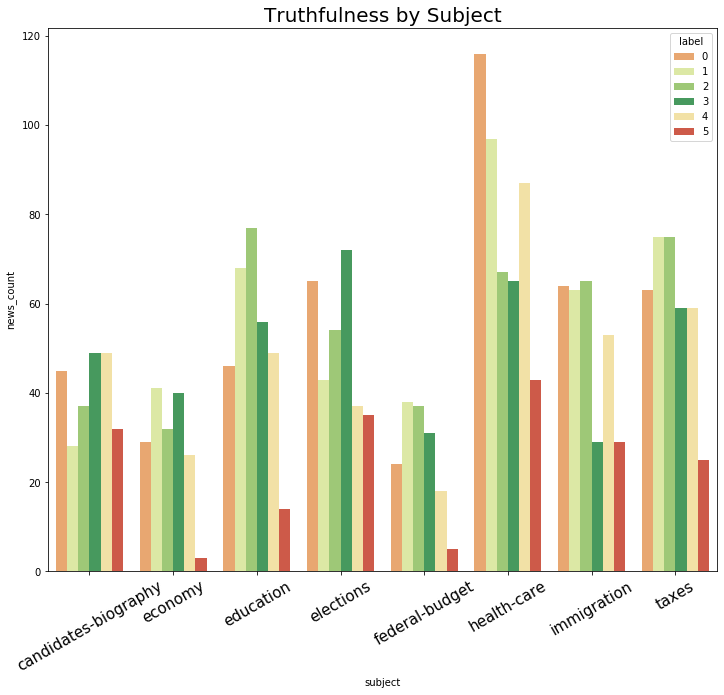

In [186]:
plt.figure(figsize=(12,10))
sns.barplot(x='subject', y = 'news_count', data = df_subject_counts, hue = 'label',
           palette=[GreenRed2[4], GreenRed2[2], GreenRed2[1],GreenRed2[0], GreenRed2[3], GreenRed2[5]])
plt.xticks(rotation = 30, size = 15)
plt.title('Truthfulness by Subject', size = 20)

C:\Users\brand\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


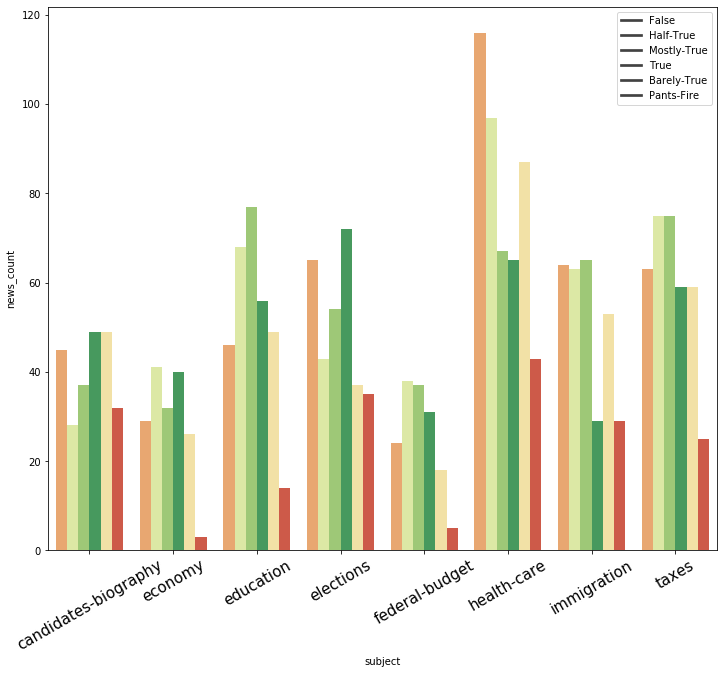

In [179]:
plt.figure(figsize=(12,10))
sns.barplot(x='subject', y = 'news_count', data = df_subject_counts, hue = 'label',
           palette=[GreenRed2[4], GreenRed2[2], GreenRed2[1],GreenRed2[0], GreenRed2[3], GreenRed2[5]])
plt.xticks(rotation = 30, size = 15)
plt.legend((GreenRed2[4], GreenRed2[2], GreenRed2[1],GreenRed2[0], GreenRed2[3], GreenRed2[5])
           ,labels=["False", "Half-True", "Mostly-True", "True", "Barely-True", "Pants-Fire"])

In [41]:
df_top_speaker = pd.DataFrame(df_full['speaker'].value_counts().iloc[:10])
df_top_speaker = df_top_speaker.reset_index()
df_top_speaker.columns = ['speaker', 'news_count']
df_top_speaker

,speaker,news_count
0,barack-obama,616
1,donald-trump,344
2,hillary-clinton,297
3,mitt-romney,216
4,john-mccain,189
5,scott-walker,184
6,chain-email,178
7,rick-perry,173
8,marco-rubio,153
9,rick-scott,150


In [47]:
palette ={"barack-obama	": "C0", "donald-trump": "C1", "hillary-clinton	": "C2", "mitt-romney": "k"}

Text(0.5, 1.0, 'News Statements by Top Speakers')

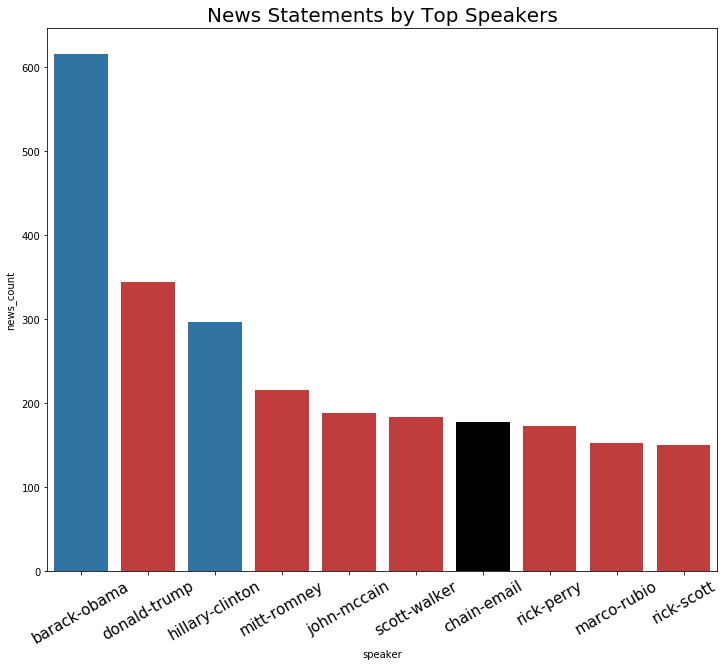

In [184]:
plt.figure(figsize=(12,10))
sns.barplot(x='speaker', y = 'news_count', data = df_top_speaker, 
            palette = ["C0", "C3", "C0", "C3", "C3", "C3", "k", "C3", "C3","C3"])
plt.xticks(rotation = 30, size = 15)
plt.title('News Statements by Top Speakers', size = 20)

In [89]:
GreenRed = sns.color_palette("RdYlGn", 5)
GreenRed.reverse()
GreenRed

[(0.29480968858131484, 0.6899653979238755, 0.3619377162629758),
 (0.7176470588235296, 0.8797385620915034, 0.45882352941176485),
 (0.9970780469050365, 0.9987697039600154, 0.7450211457131872),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9167243367935409, 0.3430219146482122, 0.22399077277970014)]

C:\Users\brand\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Truthfulness by Speaker')

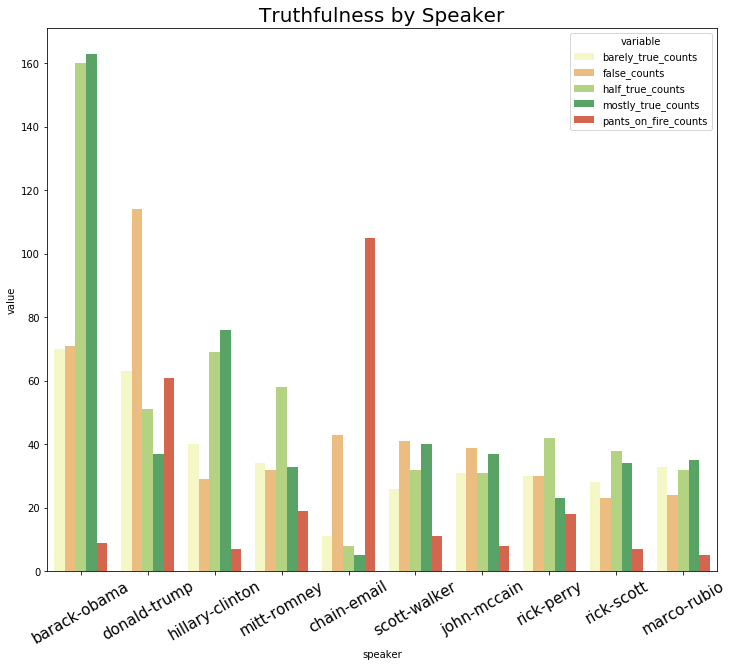

In [183]:
# Create melted DF of Category Counts
# Plot Top Speakers' Category Counts

df_speaker_TF = df_full.drop_duplicates(subset='speaker')
df_speaker_TF['news_count'] = df_speaker_TF[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']].sum(axis = 1)
df_most_speeches = df_speaker_TF.sort_values(by=['news_count'], ascending=False)[:10].drop(['news_count'], axis =1)
df_melt = pd.melt(df_most_speeches, id_vars=['speaker'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])


plt.figure(figsize=(12,10))
sns.barplot(x='speaker', y='value', data=df_melt, hue='variable', 
            palette=[GreenRed[2], GreenRed[3], GreenRed[1],GreenRed[0], GreenRed[4]])
deep_pal = sns.color_palette('deep')
plt.xticks(rotation = 30, size=15)
plt.title('Truthfulness by Speaker', size = 20)

Text(0.5, 1.0, 'Truthfulness by Party Affiliation')

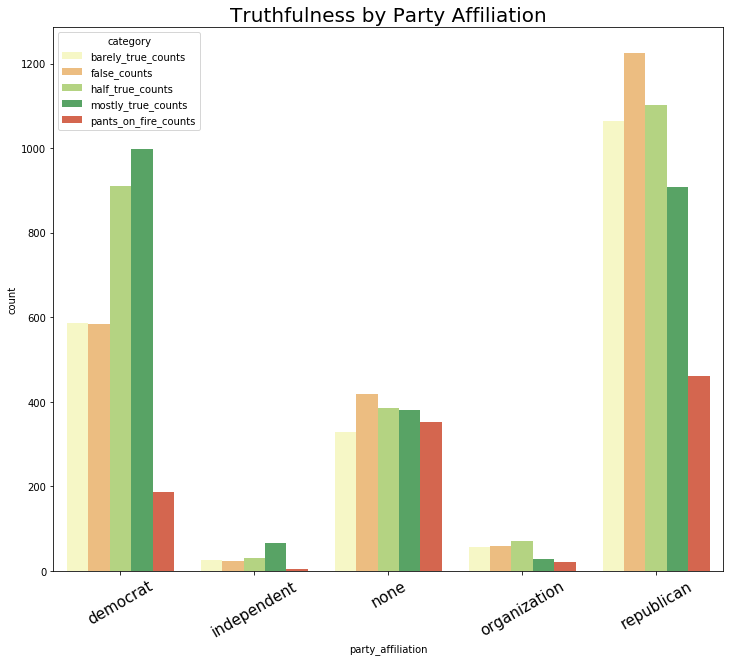

In [185]:
# Create melted DF on party affiliation
# Plot Category count by party affiliation

df_party = df_speaker_TF.groupby('party_affiliation').sum()[['barely_true_counts', 'false_counts','half_true_counts',
                                                             'mostly_true_counts', 'pants_on_fire_counts']].reset_index()
df_party_melt = pd.melt(df_party, id_vars=['party_affiliation'], value_vars=['barely_true_counts','false_counts', 'half_true_counts',
                                                          'mostly_true_counts', 'pants_on_fire_counts'])
df_party_melt = df_party_melt.rename(columns={'variable':'category', 'value':'count'})

df_top_party = df_party_melt[df_party_melt['party_affiliation'].isin(['republican','democrat','none', 'organization', 'independent'])]


plt.figure(figsize=(12,10))
sns.barplot(x='party_affiliation', y='count', data=df_top_party, hue='category', 
           palette=[GreenRed[2], GreenRed[3], GreenRed[1],GreenRed[0], GreenRed[4]])
plt.xticks(rotation = 30, size=15)
plt.title('Truthfulness by Party Affiliation', size = 20)

## EDA after Feature Engineering

In [188]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
validation= pd.DataFrame(dataset['validation'])


train_df = train.fillna('None')
test_df = test.fillna('None')
val_df = validation.fillna('None')

train = train_df.values
test = test_df.values
val = val_df.values

In [189]:
#Labeling 1 or 0 for true or not true
def label_true (row):
    if row['label'] < 3 :
        return 0
    return 1

train_df['true_false'] = train_df.apply (lambda row: label_true(row), axis=1)
test_df['true_false'] = test_df.apply (lambda row: label_true(row), axis=1)
val_df['true_false'] = val_df.apply (lambda row: label_true(row), axis=1)

In [190]:

labels = {'train':[train[i][1] for i in range(len(train))], 'test':[test[i][1] for i in range(len(test))], 'val':[val[i][1] for i in range(len(val))]}
statements = {'train':[train[i][2] for i in range(len(train))], 'test':[test[i][2] for i in range(len(test))], 'val':[val[i][2] for i in range(len(val))]}
subjects = {'train':[train[i][3] for i in range(len(train))], 'test':[test[i][3] for i in range(len(test))], 'val':[val[i][3] for i in range(len(val))]}
speakers = {'train':[train[i][4] for i in range(len(train))], 'test':[test[i][4] for i in range(len(test))], 'val':[val[i][4] for i in range(len(val))]}
jobs = {'train':[train[i][5] for i in range(len(train))], 'test':[test[i][5] for i in range(len(test))], 'val':[val[i][5] for i in range(len(val))]}
states = {'train':[train[i][6] for i in range(len(train))], 'test':[test[i][6] for i in range(len(test))], 'val':[val[i][6] for i in range(len(val))]}
affiliations = {'train':[train[i][7] for i in range(len(train))], 'test':[test[i][7] for i in range(len(test))], 'val':[val[i][7] for i in range(len(val))]}
credits = {'train':[train[i][8:13] for i in range(len(train))], 'test':[test[i][8:13] for i in range(len(test))], 'val':[val[i][8:13] for i in range(len(val))]}
contexts= {'train':[train[i][13] for i in range(len(train))], 'test':[test[i][13] for i in range(len(test))], 'val':[val[i][13] for i in range(len(val))]}

In [191]:
#Combine the metadata so we can use this as an input
metadata = {'train':[0]*len(train), 'val':[0]*len(val), 'test':[0]*len(test)}


for i in range(len(train)):
    subject = subjects['train'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['train'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['train'][i]
    if job == 0:
        job = 'None'
    
    state = states['train'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['train'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['train'][i]
    if context== 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    #subject_train.append(subject)
    #speaker_train.append(speaker)
    #job_train.append(job)
    #state_train.append(state)
    #affiliation_train.append(affiliation)
    #context_train.append(context)
    
    metadata['train'][i] = meta
    
for i in range(len(val)):
    subject = subjects['val'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['val'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['val'][i]
    if job == 0:
        job = 'None'
    
    state = states['val'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['val'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['val'][i]
    if context == 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    metadata['val'][i] = meta
    
for i in range(len(test)):
    subject = subjects['test'][i]
    if subject == 0:
        subject = 'None'
    
    speaker = speakers['test'][i]
    if speaker == 0:
        speaker = 'None'
    
    job = jobs['test'][i]
    if job == 0:
        job = 'None'
    
    state = states['test'][i]
    if state == 0:
        state = 'None'

    affiliation = affiliations['test'][i]
    if affiliation == 0:
        affiliation = 'None'

    context = contexts['test'][i]
    if context == 0 :
        context = 'None'
        
    meta = subject + ' ' + speaker + ' ' + job + ' ' + state + ' ' + affiliation + ' ' + context
    
    metadata['test'][i] = meta

In [192]:
train_df['metadata']= metadata['train']
test_df['metadata']= metadata['test']
val_df['metadata']= metadata['val']

In [199]:
train_df.true_false.value_counts()

0    6087
1    4182
Name: true_false, dtype: int64

In [193]:
X_train_statement = train_df['statement']
X_test_statement = test_df['statement']
X_val_statement = val_df['statement']

y_train = train_df['true_false']
y_val = val_df['true_false']
y_test = test_df['true_false']

print(X_train_statement.shape, X_test_statement.shape, X_val_statement.shape)
print(y_train.shape, y_test.shape,y_val.shape)

(10269,) (1283,) (1284,)
(10269,) (1283,) (1284,)


In [290]:
df_full2 = pd.concat([train_df, test_df, val_df])

In [291]:
df_full2.head(2)

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,true_false,metadata
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0,abortion dwayne-bohac State representative Tex...
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,"energy,history,job-accomplishments scott-surov..."


In [293]:
df_full2 = df_full2[df_full2.party_affiliation.isin(['republican','democrat','none', 'organization', 'independent'])]

In [294]:
df_full2 = df_full2[['party_affiliation', 'true_false', 'id']]

In [295]:
df_full2 = df_full2.groupby(['party_affiliation', 'true_false']).count()
# df_full2 = df_full2.reset_index()
df_full2

id
party_affiliation true_false      
democrat          0           2569
                  1           1581
independent       0            121
                  1             61
none              0           1194
                  1            991
organization      0            158
                  1            107
republican        0           3348
                  1           2339

In [304]:
df_full2 = df_full2.rename({'id':'news_count'}, inplace=False, axis=1)
df_full2 = df_full2.reset_index(level=[0,1])
df_full2

,party_affiliation,true_false,news_count
0,democrat,0,2569
1,democrat,1,1581
2,independent,0,121
3,independent,1,61
4,none,0,1194
5,none,1,991
6,organization,0,158
7,organization,1,107
8,republican,0,3348
9,republican,1,2339


Text(0.5, 1.0, 'Truthfulness by Party Affiliation')

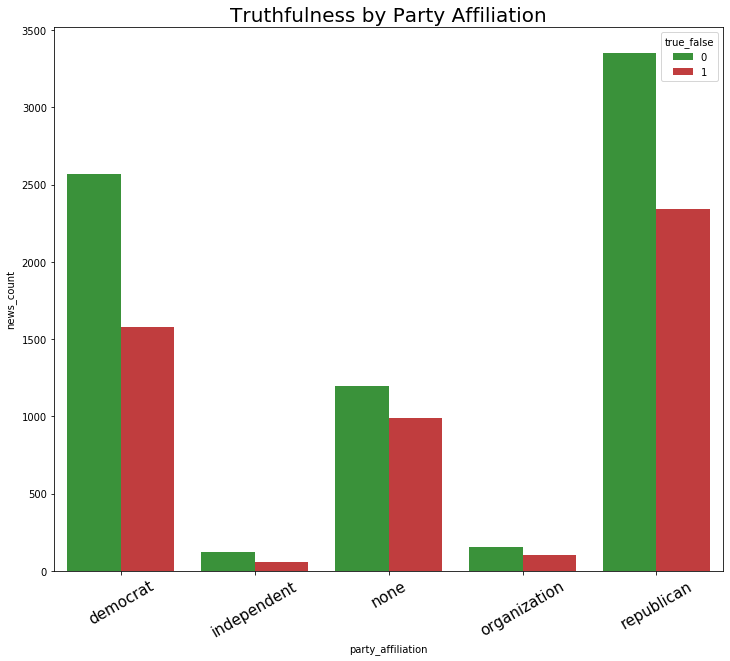

In [310]:
plt.figure(figsize=(12,10))
sns.barplot(x='party_affiliation', y = 'news_count', data = df_full2, hue = 'true_false', 
           palette = ["C2", "C3"])
plt.xticks(rotation = 30, size = 15)
plt.title('Truthfulness by Party Affiliation', size = 20)

In [337]:
df_full3 = pd.concat([train_df, test_df, val_df])

In [338]:
df_full3 = df_full3[df_full3.speaker.isin(['barack-obama','donald-trump','hillary-clinton', 'mitt-romney', 'john-mccain',
                                          'scott-walker', 'chain-email', 'bernie-s', 'marco-rubio', 'rick-scott', 'rick-perry'])]
df_full3

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,true_false,metadata
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0,foreign-policy barack-obama President Illinois...
7,153.json,1,"""I'm the only person on this stage who has wor...",ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0,ethics barack-obama President Illinois democra...
11,4148.json,1,"Since 2000, nearly 12 million Americans have s...","economy,jobs,new-hampshire-2012,poverty",bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,a tweet,0,"economy,jobs,new-hampshire-2012,poverty bernie..."
12,5947.json,0,When Mitt Romney was governor of Massachusetts...,"history,state-budget",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,an interview with CBN News,0,"history,state-budget mitt-romney Former govern..."
15,10683.json,1,"In this last election in November, ... 63 perc...",elections,bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,"a town hall in Austin, Texas",0,elections bernie-s U.S. Senator Vermont indepe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1431.json,0,"""We've excluded lobbyists from policymaking jo...",ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,his State of the Union address,0,ethics barack-obama President Illinois democra...
1272,4104.json,1,Social Security and other federal checks may n...,"deficit,federal-budget,social-security",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,an interview with CBS News,0,"deficit,federal-budget,social-security barack-..."
1275,278.json,0,"""I supported (the surge), I argued for it. I'm...",iraq,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,"a debate in Myrtle Beach, S.C.",0,iraq john-mccain U.S. senator Arizona republic...
1279,3419.json,1,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference,0,"energy,oil-spill,trade barack-obama President ..."


In [339]:
df_full3 = df_full3[['speaker', 'true_false', 'id']]

In [340]:
df_full3 = df_full3.groupby(['speaker', 'true_false']).count()

In [341]:
df_full3 = df_full3.rename({'id':'news_count'}, inplace=False, axis=1)
df_full3 = df_full3.reset_index(level=[0,1])
df_full3

,speaker,true_false,news_count
0,barack-obama,0,412
1,barack-obama,1,204
2,bernie-s,0,75
3,bernie-s,1,32
4,chain-email,0,56
5,chain-email,1,122
6,donald-trump,0,206
7,donald-trump,1,138
8,hillary-clinton,0,177
9,hillary-clinton,1,120


Text(0.5, 1.0, 'Truthfulness by Speaker')

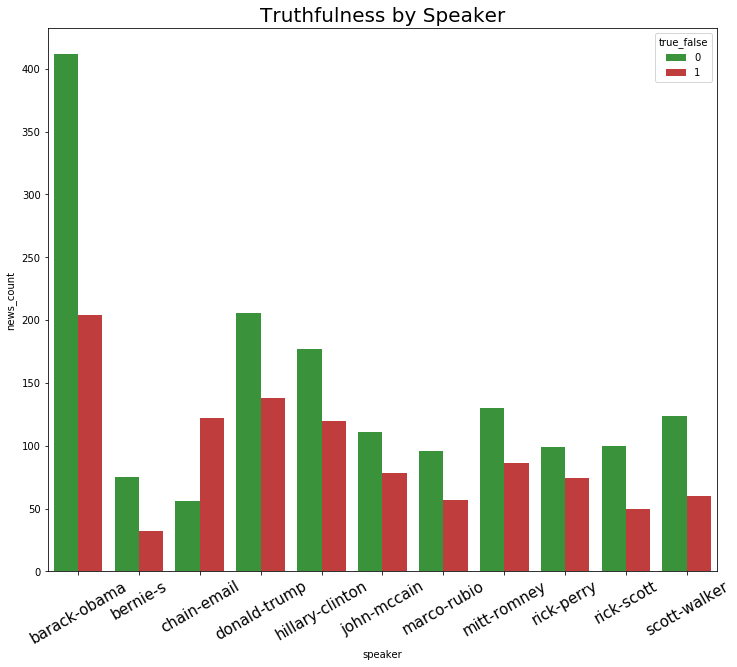

In [342]:
plt.figure(figsize=(12,10))
sns.barplot(x='speaker', y = 'news_count', data = df_full3, hue = 'true_false', 
           palette = ["C2", "C3"])
plt.xticks(rotation = 30, size = 15)
plt.title('Truthfulness by Speaker', size = 20)

In [247]:
import numpy as np
tf_df = pd.DataFrame([[7615, 5221]], columns = ['True', 'False'])

In [249]:
tf_df

,True,False
0,7615,5221


In [239]:
tf_df = np.array(df_full2.true_false.value_counts())

In [262]:
tf_df = np.array(df_full2.true_false.value_counts())
tf_df = pd.DataFrame(np.array(tf_df).T, columns = ['TF Count'])
tf_df

,TF Count
0,7615
1,5221
